In [ ]:
from google.colab import files
files.upload()

In [1]:
!kaggle datasets download -d vuppalaadithyasairam/bone-fracture-detection-using-xrays

Dataset URL: https://www.kaggle.com/datasets/vuppalaadithyasairam/bone-fracture-detection-using-xrays
License(s): unknown
100% 172M/172M [00:02<00:00, 80.8MB/s]
100% 172M/172M [00:02<00:00, 75.2MB/s]


# Dataset Loading

In [2]:
import zipfile
import os

# Path to the zip file and extraction path
zip_file_path = "/content/bone-fracture-detection-using-xrays.zip"
extraction_path = "/content/classifier_dataset"

# Unzipping the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print("Unzipping completed!")


Unzipping completed!


In [ ]:
!pip install --upgrade tensorflow

  Using cached tensorflow-2.16.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (589.8 MB)
  Using cached keras-3.3.3-py3-none-any.whl (1.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.


In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import PIL
import PIL.Image

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths to the dataset
train_dir = '/content/classifier_dataset/archive (6)/train'
test_dir = '/content/classifier_dataset/archive (6)/val'

# Initialize ImageDataGenerator with normalization and augmentation for the training data
train_datagen = ImageDataGenerator(
    rescale=1./255,        # Normalize pixel values
    rotation_range=20,     # Random rotation
    width_shift_range=0.2, # Random width shift
    height_shift_range=0.2,# Random height shift
    shear_range=0.2,       # Shear transformations
    zoom_range=0.2,        # Zoom into images
    horizontal_flip=True,  # Allow horizontal flips
    fill_mode='nearest'
)

# Initialize ImageDataGenerator with only normalization for the validation data
test_datagen = ImageDataGenerator(rescale=1./255)


In [7]:
# Set image size and batch size
image_size = (150, 150)
batch_size = 32

# Load and transform images from the training directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

# Load images from the validation directory
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


# Visualization of dataset

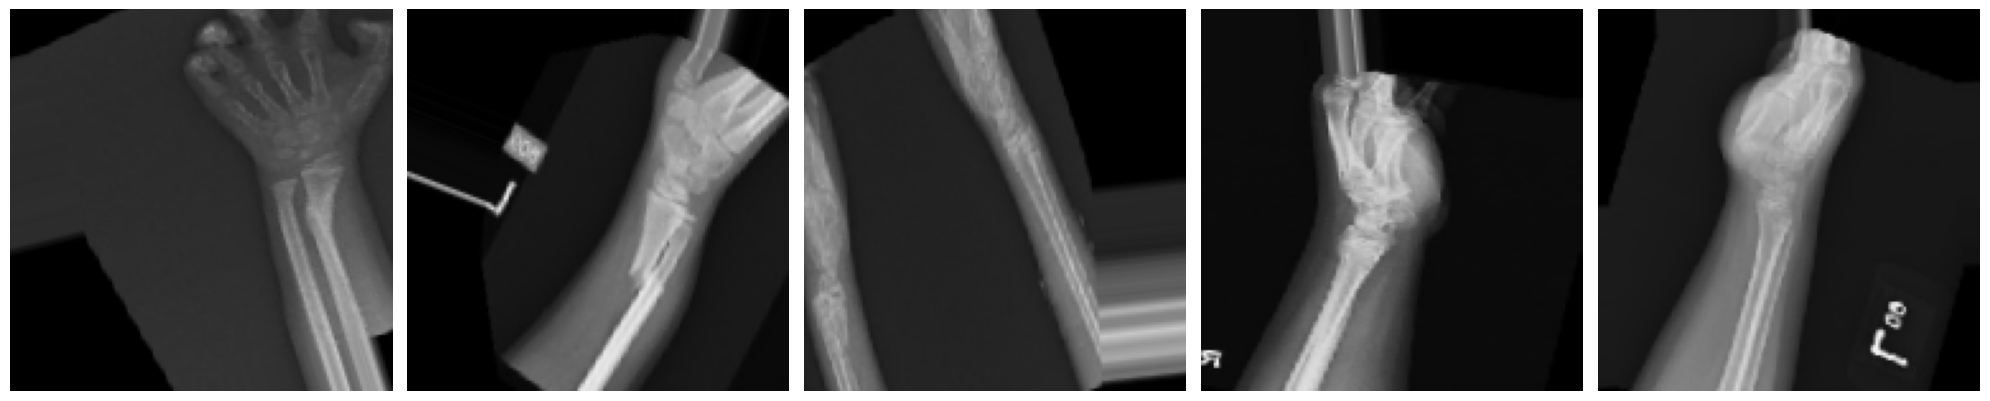

In [8]:
import matplotlib.pyplot as plt

# Function to plot images in the form of a grid with 1 row and 5 columns where images are placed
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of images
images, labels = next(train_generator)

# Plot the images
plot_images(images[:5])  # Plot the first 5 images


# Check for Class Imbalance

In [9]:
import os

def count_images(directory):
    categories = {}
    # List all items in the directory
    for item in os.listdir(directory):
        path = os.path.join(directory, item)

        if os.path.isdir(path):
            # Count files in the directory
            count = len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])
            categories[item] = count
    return categories


# Count images in each directory
train_counts = count_images(train_dir)
test_counts = count_images(test_dir)


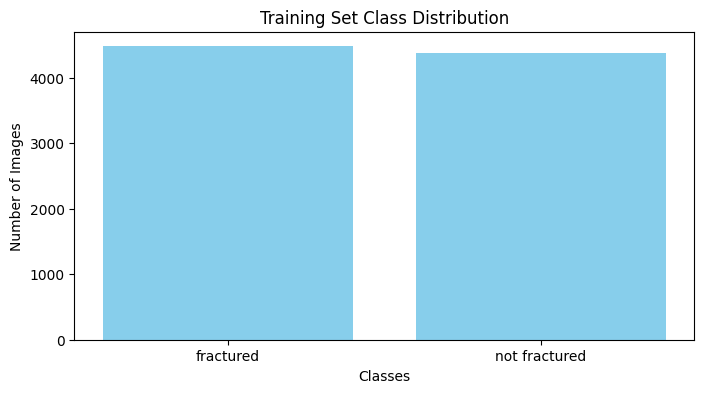

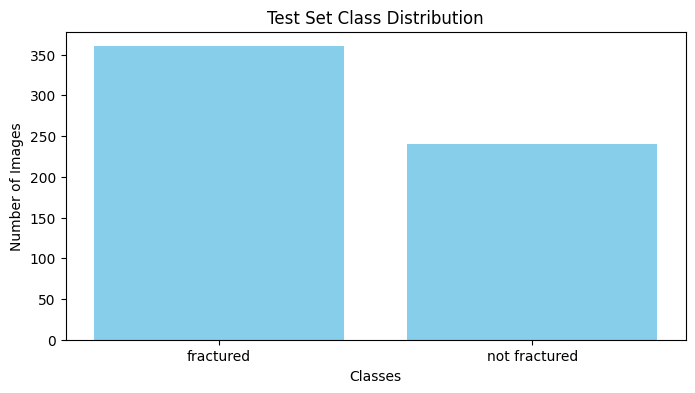

In [10]:
import matplotlib.pyplot as plt

def plot_class_distribution(counts, title):
    # Prepare the data for plotting
    categories = list(counts.keys())
    counts = list(counts.values())

    plt.figure(figsize=(8, 4))
    plt.bar(categories, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.show()

# Plotting the class distribution for training and validation sets
plot_class_distribution(train_counts, 'Training Set Class Distribution')
plot_class_distribution(test_counts, 'Test Set Class Distribution')


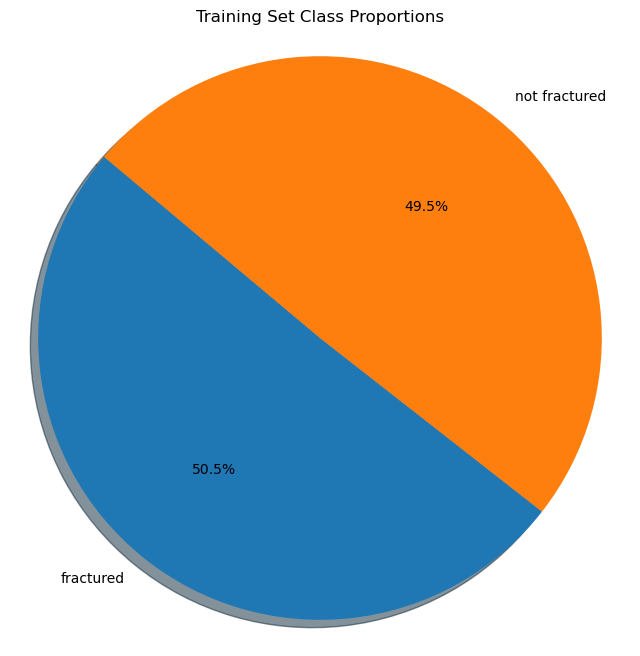

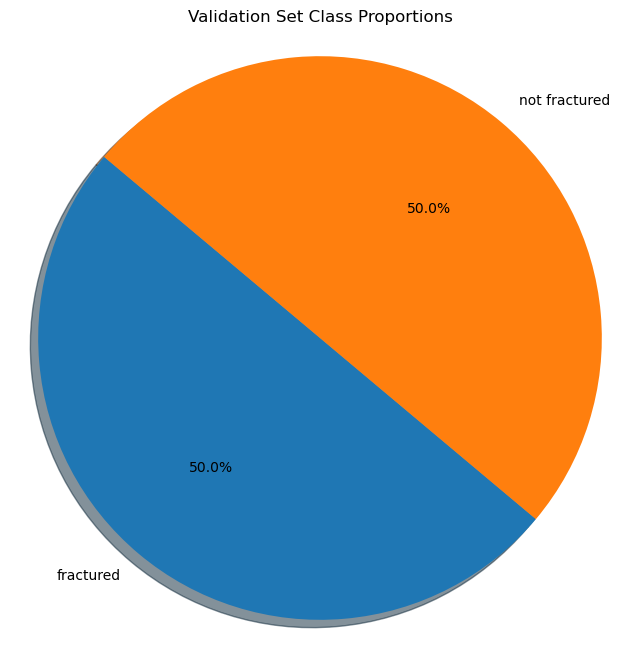

In [ ]:
def plot_pie_chart(counts, title):
    # Prepare the data for plotting
    categories = list(counts.keys())
    sizes = list(counts.values())

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=categories, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(title)
    plt.show()

# Plotting pie charts for training and validation sets
plot_pie_chart(train_counts, 'Training Set Class Proportions')
plot_pie_chart(test_counts, 'Validation Set Class Proportions')


# Class Imbalance correction

In [ ]:
# in test set we have class imbalance so we use oversampling to increase minority class data

In [ ]:
import os
from shutil import copy2
from random import choice

def oversample_validation_set(directory):
    # Calculate the number of images in each class
    categories = {}
    for category in os.listdir(directory):
        path = os.path.join(directory, category)
        images = os.listdir(path)
        categories[category] = len(images)

    # Find the maximum count to balance all classes to this count
    max_count = max(categories.values())

    # Oversample each class to the maximum count
    for category, count in categories.items():
        path = os.path.join(directory, category)
        images = os.listdir(path)
        while count < max_count:

            image_to_copy = choice(images)
            original_image_path = os.path.join(path, image_to_copy)
            new_image_path = os.path.join(path, f'copy_{count}_{image_to_copy}')
            # Copy the image within the same class directory
            copy2(original_image_path, new_image_path)
            count += 1

oversample_validation_set(test_dir)

# Set up your ImageDataGenerator with rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 720 images belonging to 2 classes.


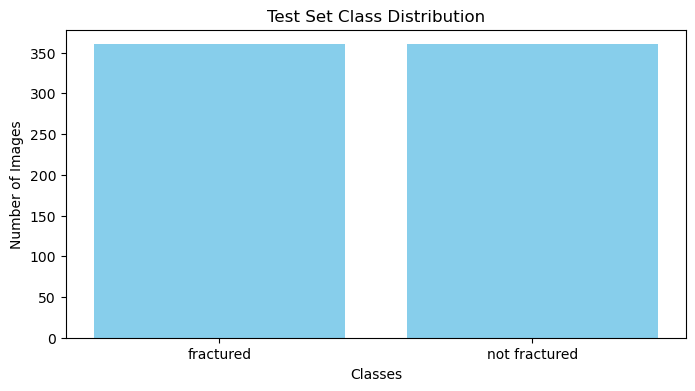

In [ ]:
#visualize the updated results
test_counts = count_images(test_dir)

plot_class_distribution(test_counts, 'Test Set Class Distribution')

# DEEP Learning Models

# 1) MLP

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout

# Model definition
model = Sequential([
    Input(shape=(150, 150, 3)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='accuracy',
    patience=2,
    restore_best_weights=True
)

# Train the model with early stopping
history = model.fit(
    train_generator,
    epochs=10,
    callbacks=[early_stopping]  # Add early stopping callback
)


Epoch 1/10


d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


277/277 ━━━━━━━━━━━━━━━━━━━━ 74s 260ms/step - accuracy: 0.5147 - loss: 3.7756
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 53s 188ms/step - accuracy: 0.5124 - loss: 0.6922
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 53s 188ms/step - accuracy: 0.5388 - loss: 0.6906
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 52s 186ms/step - accuracy: 0.5353 - loss: 0.6922
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 52s 186ms/step - accuracy: 0.4902 - loss: 0.6947


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss: {}, Test Accuracy: {}".format(test_loss, test_accuracy))


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.3317 - loss: 0.6861
Test Loss: 0.6828110814094543, Test Accuracy: 0.5666666626930237


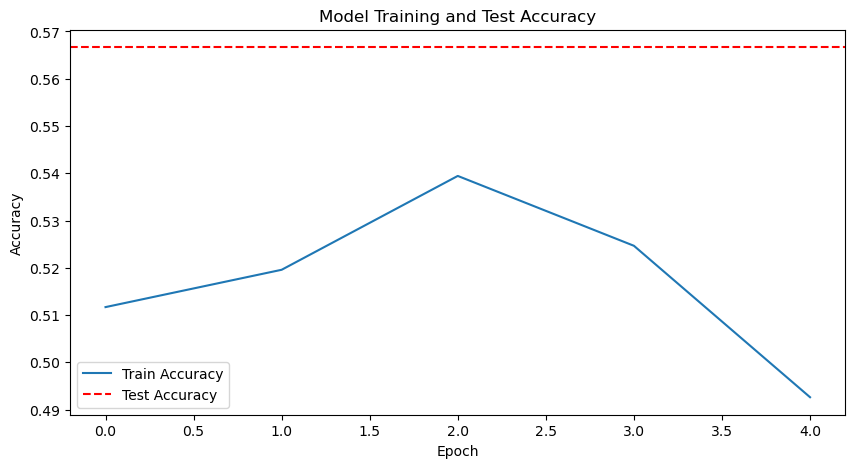

In [ ]:
import matplotlib.pyplot as plt

# Plot training accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Model Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#Evakuation metrics


import numpy as np

# Obtain predictions
predictions = model.predict(test_generator)
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary labels
from sklearn.metrics import confusion_matrix

true_labels = np.array([])
for _, labels in test_generator:
    true_labels = np.concatenate([true_labels, labels])

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)
TN, FP, FN, TP = cm.ravel()

precision = TP / (TP + FP)  # Precision: TP / (TP + FP)
recall = TP / (TP + FN)  # Recall or Sensitivity: TP / (TP + FN)
specificity = TN / (TN + FP)  # Specificity: TN / (TN + FP)

# Printing the metrics
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
# Evaluate model with accuracy
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}")

# Print other metrics
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step


KeyboardInterrupt: 

using cross-validation and grid search cv

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from sklearn.base import BaseEstimator, ClassifierMixin

class KerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, neurons=512, dropout_rate=0.5, epochs=10, batch_size=32):
        # Initializer for parameters
        self.neurons = neurons
        self.dropout_rate = dropout_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    def fit(self, generator, **kwargs):
        # This generator is expected to be like train_generator
        self.model = Sequential([
            Flatten(input_shape=(150, 150, 3)),
            Dense(self.neurons, activation='relu'),
            Dropout(self.dropout_rate),
            Dense(256, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        # Fit the model
        return self.model.fit(generator, epochs=self.epochs, steps_per_epoch=kwargs.get('steps_per_epoch', None), verbose=1)

    def predict(self, generator):
        # Predicting with a generator
        predictions = self.model.predict(generator, steps=len(generator))
        return (predictions > 0.5).astype("int32")

    def score(self, generator):
        # Scoring with a generator
        results = self.model.evaluate(generator, steps=len(generator))
        return results[1]  # Return the accuracy as the score

# The use of **kwargs allows for additional parameters such as steps_per_epoch to be passed if needed


In [ ]:
from sklearn.model_selection import GridSearchCV

# Instantiate the custom KerasClassifier
model = KerasClassifier()

# Define the grid search parameters
param_grid = {
    'neurons': [256, 512],
    'dropout_rate': [0.3, 0.5],
    'epochs': [10, 20],
    'batch_size': [32, 64]
}

# Setup GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=1)
grid_result = grid.fit(train_generator, steps_per_epoch=10)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Evaluation on test set
test_accuracy = grid.best_estimator_.score(test_generator)
print("Test Accuracy: {}".format(test_accuracy))


d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
Epoch 1/10
Epoch 1/20
Epoch 1/20
Epoch 1/10
Epoch 1/10
Epoch 1/20
Epoch 1/20
Epoch 1/10
Epoch 1/10
Epoch 1/20
Epoch 1/20
Epoch 1/10
Epoch 1/10
Epoch 1/20
Epoch 1/20


ValueError: 
All the 48 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 893, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "C:\Users\hexlab\AppData\Local\Temp\ipykernel_55560\1814803213.py", line 25, in fit
    return self.model.fit(generator, epochs=self.epochs, steps_per_epoch=kwargs.get('steps_per_epoch', None), verbose=1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py", line 114, in check_data_cardinality
    raise ValueError(msg)
ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 31, 31


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 893, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "C:\Users\hexlab\AppData\Local\Temp\ipykernel_55560\1814803213.py", line 25, in fit
    return self.model.fit(generator, epochs=self.epochs, steps_per_epoch=kwargs.get('steps_per_epoch', None), verbose=1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py", line 114, in check_data_cardinality
    raise ValueError(msg)
ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 31, 31


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 893, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "C:\Users\hexlab\AppData\Local\Temp\ipykernel_55560\1814803213.py", line 25, in fit
    return self.model.fit(generator, epochs=self.epochs, steps_per_epoch=kwargs.get('steps_per_epoch', None), verbose=1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\layers\input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_15" is incompatible with the layer: expected axis -1 of input shape to have value 67500, but received input with shape (4, 150528)[0m

Arguments received by Sequential.call():
  • inputs=(('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'))
  • training=True
  • mask=(('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'))

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 893, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "C:\Users\hexlab\AppData\Local\Temp\ipykernel_55560\1814803213.py", line 25, in fit
    return self.model.fit(generator, epochs=self.epochs, steps_per_epoch=kwargs.get('steps_per_epoch', None), verbose=1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\layers\input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_24" is incompatible with the layer: expected axis -1 of input shape to have value 67500, but received input with shape (4, 150528)[0m

Arguments received by Sequential.call():
  • inputs=(('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'))
  • training=True
  • mask=(('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'))

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 893, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "C:\Users\hexlab\AppData\Local\Temp\ipykernel_55560\1814803213.py", line 25, in fit
    return self.model.fit(generator, epochs=self.epochs, steps_per_epoch=kwargs.get('steps_per_epoch', None), verbose=1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\layers\input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_33" is incompatible with the layer: expected axis -1 of input shape to have value 67500, but received input with shape (4, 150528)[0m

Arguments received by Sequential.call():
  • inputs=(('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'))
  • training=True
  • mask=(('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'))

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 893, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "C:\Users\hexlab\AppData\Local\Temp\ipykernel_55560\1814803213.py", line 25, in fit
    return self.model.fit(generator, epochs=self.epochs, steps_per_epoch=kwargs.get('steps_per_epoch', None), verbose=1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\layers\input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_42" is incompatible with the layer: expected axis -1 of input shape to have value 67500, but received input with shape (4, 150528)[0m

Arguments received by Sequential.call():
  • inputs=(('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'))
  • training=True
  • mask=(('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'))

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 893, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "C:\Users\hexlab\AppData\Local\Temp\ipykernel_55560\1814803213.py", line 25, in fit
    return self.model.fit(generator, epochs=self.epochs, steps_per_epoch=kwargs.get('steps_per_epoch', None), verbose=1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\layers\input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_51" is incompatible with the layer: expected axis -1 of input shape to have value 67500, but received input with shape (4, 150528)[0m

Arguments received by Sequential.call():
  • inputs=(('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'))
  • training=True
  • mask=(('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'))

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 893, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "C:\Users\hexlab\AppData\Local\Temp\ipykernel_55560\1814803213.py", line 25, in fit
    return self.model.fit(generator, epochs=self.epochs, steps_per_epoch=kwargs.get('steps_per_epoch', None), verbose=1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\layers\input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_60" is incompatible with the layer: expected axis -1 of input shape to have value 67500, but received input with shape (4, 150528)[0m

Arguments received by Sequential.call():
  • inputs=(('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'))
  • training=True
  • mask=(('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'))

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 893, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "C:\Users\hexlab\AppData\Local\Temp\ipykernel_55560\1814803213.py", line 25, in fit
    return self.model.fit(generator, epochs=self.epochs, steps_per_epoch=kwargs.get('steps_per_epoch', None), verbose=1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\layers\input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_69" is incompatible with the layer: expected axis -1 of input shape to have value 67500, but received input with shape (4, 150528)[0m

Arguments received by Sequential.call():
  • inputs=(('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'))
  • training=True
  • mask=(('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'))

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 893, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "C:\Users\hexlab\AppData\Local\Temp\ipykernel_55560\1814803213.py", line 25, in fit
    return self.model.fit(generator, epochs=self.epochs, steps_per_epoch=kwargs.get('steps_per_epoch', None), verbose=1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\layers\input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_78" is incompatible with the layer: expected axis -1 of input shape to have value 67500, but received input with shape (4, 150528)[0m

Arguments received by Sequential.call():
  • inputs=(('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'))
  • training=True
  • mask=(('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'))

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 893, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "C:\Users\hexlab\AppData\Local\Temp\ipykernel_55560\1814803213.py", line 25, in fit
    return self.model.fit(generator, epochs=self.epochs, steps_per_epoch=kwargs.get('steps_per_epoch', None), verbose=1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\layers\input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_87" is incompatible with the layer: expected axis -1 of input shape to have value 67500, but received input with shape (4, 150528)[0m

Arguments received by Sequential.call():
  • inputs=(('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'))
  • training=True
  • mask=(('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'))

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 893, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "C:\Users\hexlab\AppData\Local\Temp\ipykernel_55560\1814803213.py", line 25, in fit
    return self.model.fit(generator, epochs=self.epochs, steps_per_epoch=kwargs.get('steps_per_epoch', None), verbose=1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\layers\input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_96" is incompatible with the layer: expected axis -1 of input shape to have value 67500, but received input with shape (4, 150528)[0m

Arguments received by Sequential.call():
  • inputs=(('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'))
  • training=True
  • mask=(('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'))

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 893, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "C:\Users\hexlab\AppData\Local\Temp\ipykernel_55560\1814803213.py", line 25, in fit
    return self.model.fit(generator, epochs=self.epochs, steps_per_epoch=kwargs.get('steps_per_epoch', None), verbose=1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\layers\input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_105" is incompatible with the layer: expected axis -1 of input shape to have value 67500, but received input with shape (4, 150528)[0m

Arguments received by Sequential.call():
  • inputs=(('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'))
  • training=True
  • mask=(('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'))

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 893, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "C:\Users\hexlab\AppData\Local\Temp\ipykernel_55560\1814803213.py", line 25, in fit
    return self.model.fit(generator, epochs=self.epochs, steps_per_epoch=kwargs.get('steps_per_epoch', None), verbose=1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\layers\input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_114" is incompatible with the layer: expected axis -1 of input shape to have value 67500, but received input with shape (4, 150528)[0m

Arguments received by Sequential.call():
  • inputs=(('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'))
  • training=True
  • mask=(('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'))

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 893, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "C:\Users\hexlab\AppData\Local\Temp\ipykernel_55560\1814803213.py", line 25, in fit
    return self.model.fit(generator, epochs=self.epochs, steps_per_epoch=kwargs.get('steps_per_epoch', None), verbose=1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\layers\input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_123" is incompatible with the layer: expected axis -1 of input shape to have value 67500, but received input with shape (4, 150528)[0m

Arguments received by Sequential.call():
  • inputs=(('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'))
  • training=True
  • mask=(('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'))

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 893, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "C:\Users\hexlab\AppData\Local\Temp\ipykernel_55560\1814803213.py", line 25, in fit
    return self.model.fit(generator, epochs=self.epochs, steps_per_epoch=kwargs.get('steps_per_epoch', None), verbose=1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\layers\input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_132" is incompatible with the layer: expected axis -1 of input shape to have value 67500, but received input with shape (4, 150528)[0m

Arguments received by Sequential.call():
  • inputs=(('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'))
  • training=True
  • mask=(('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'))

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 893, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "C:\Users\hexlab\AppData\Local\Temp\ipykernel_55560\1814803213.py", line 25, in fit
    return self.model.fit(generator, epochs=self.epochs, steps_per_epoch=kwargs.get('steps_per_epoch', None), verbose=1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\layers\input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_141" is incompatible with the layer: expected axis -1 of input shape to have value 67500, but received input with shape (4, 150528)[0m

Arguments received by Sequential.call():
  • inputs=(('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'))
  • training=True
  • mask=(('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'))

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 893, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "C:\Users\hexlab\AppData\Local\Temp\ipykernel_55560\1814803213.py", line 25, in fit
    return self.model.fit(generator, epochs=self.epochs, steps_per_epoch=kwargs.get('steps_per_epoch', None), verbose=1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "d:\pinokio\api\oobabooga.pinokio.git\text-generation-webui\installer_files\env\Lib\site-packages\keras\src\layers\input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_150" is incompatible with the layer: expected axis -1 of input shape to have value 67500, but received input with shape (4, 150528)[0m

Arguments received by Sequential.call():
  • inputs=(('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'), ('tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(4,), dtype=float32)'))
  • training=True
  • mask=(('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'), ('None', 'None'))


# 2) CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='accuracy',
    patience=3,
    restore_best_weights=True
)


In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    callbacks=[early_stopping]
)


Epoch 1/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 54s 188ms/step - accuracy: 0.5464 - loss: 0.7002
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 53s 188ms/step - accuracy: 0.5860 - loss: 0.6653
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 53s 188ms/step - accuracy: 0.5954 - loss: 0.6526
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 52s 187ms/step - accuracy: 0.6203 - loss: 0.6317
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 52s 187ms/step - accuracy: 0.6704 - loss: 0.5879
Epoch 6/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 53s 188ms/step - accuracy: 0.7083 - loss: 0.5542
Epoch 7/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 53s 187ms/step - accuracy: 0.7213 - loss: 0.5295
Epoch 8/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 53s 188ms/step - accuracy: 0.7554 - loss: 0.4836
Epoch 9/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 53s 189ms/step - accuracy: 0.7937 - loss: 0.4364
Epoch 10/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 53s 189ms/step - accuracy: 0.8012 - loss: 0.4178


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6754 - loss: 0.5280
Test Loss: 0.643917441368103, Test Accuracy: 0.5888888835906982


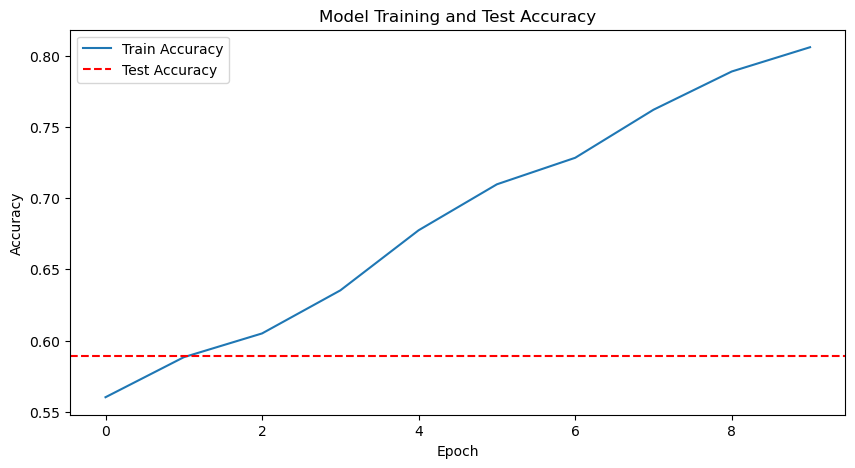

In [ ]:
import matplotlib.pyplot as plt

# Plot training accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Model Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# 3) Transfer Learning

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout

# Load VGG16 pre-trained on ImageNet data, without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers except for the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add new classifier layers on top of VGG16 base
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Assuming binary classification

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='accuracy',
    patience=3,
    restore_best_weights=True
)


In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    callbacks=[early_stopping]
)


Epoch 1/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 112s 399ms/step - accuracy: 0.4984 - loss: 0.7493
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 111s 398ms/step - accuracy: 0.4931 - loss: 0.6933
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 111s 397ms/step - accuracy: 0.5095 - loss: 0.6931
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 111s 399ms/step - accuracy: 0.4868 - loss: 0.6934
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 110s 396ms/step - accuracy: 0.4965 - loss: 0.6934
Epoch 6/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 112s 400ms/step - accuracy: 0.4965 - loss: 0.6934


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 325ms/step - accuracy: 0.8145 - loss: 0.6885
Test Loss: 0.6931753158569336, Test Accuracy: 0.5


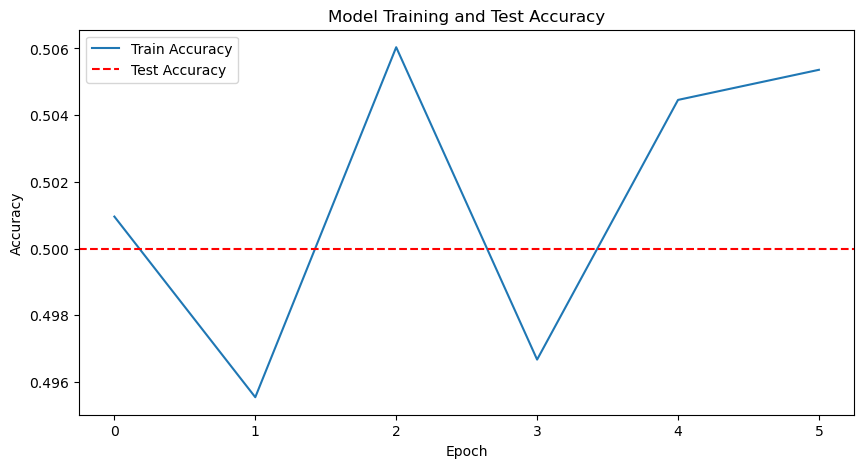

In [ ]:
import matplotlib.pyplot as plt

# Plot training accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Model Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Advance Task

# Vision Transformer

In [ ]:
!pip install tensorflow transformers

In [ ]:
image_size = (224, 224)  # Updated size

# Initialize ImageDataGenerators again with updated image size
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',  # 'binary' outputs 1D binary labels
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 8863 images belonging to 2 classes.
Found 720 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0


In [ ]:
# Define the base model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))

# Adding custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Suitable for binary classification

# Construct the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Epoch 1/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 287s 946ms/step - accuracy: 0.8013 - loss: 0.4000
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 258s 926ms/step - accuracy: 0.9647 - loss: 0.1044
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 269s 965ms/step - accuracy: 0.9831 - loss: 0.0532
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 259s 931ms/step - accuracy: 0.9876 - loss: 0.0351
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 259s 929ms/step - accuracy: 0.9879 - loss: 0.0331
Epoch 6/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 260s 933ms/step - accuracy: 0.9906 - loss: 0.0307
Epoch 7/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 261s 937ms/step - accuracy: 0.9843 - loss: 0.0375
Epoch 8/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 261s 938ms/step - accuracy: 0.9928 - loss: 0.0224
Epoch 9/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 262s 941ms/step - accuracy: 0.9935 - loss: 0.0210
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.7505 - loss: 1.7748
Test Loss: 4.003087520599365, Test Accuracy: 0.5305555462837219


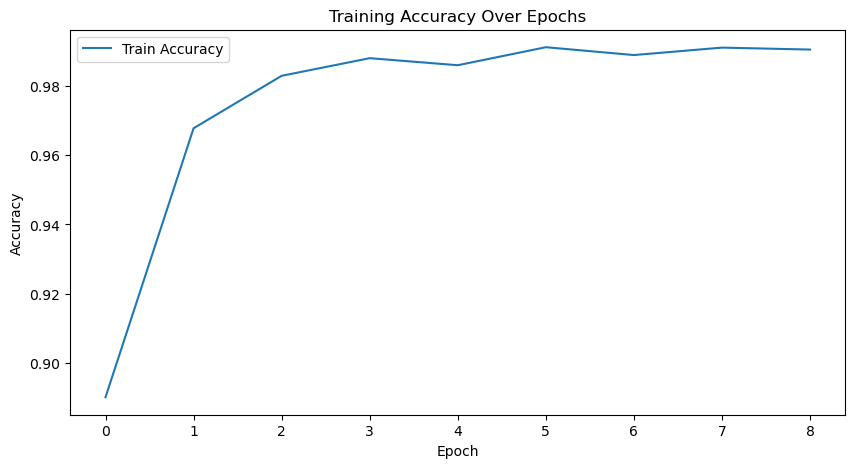

In [ ]:
# Assuming train_generator and test_generator are already set up
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback to monitor accuracy
early_stopping = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Plot the training results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
